In [1]:
print(os.getcwd())

/Users/bren/dsan-23-scholarship/miniproject


In [3]:
# The first step is to get the data into a usable format. 
# We have two folders, named DC and USA.  Each contains a number of JSON files
# The goal is to read the JSON files and create a single pandas dataframe per folder

import pandas as pd
import json
import re
import os 

def format_nested(data, key, colname, valname):
    '''
    Special function to format the nested job highlights data
    '''
    # Creating a list to store the dictionaries
    jobs_data = []

    # Iterate through each job in the data
    for job in data:
        # Get the job_highlights for the current job
        job_highlights = job[key]
        
        # Create a dictionary to store the highlights for the current job
        job_dict = {}
        
        # Iterate through the job_highlights and add them to the job_dict
        for highlight in job_highlights:
            
            # If title is not in the column names, skip
            if colname not in highlight:
                continue
            
            # Get the column name from the 'title' key
            column_name = highlight[colname]
            
            # Get the values from the 'items' key
            values = highlight[valname]
            
            # Add the values to the job_dict under the column name
            job_dict[column_name] = values
        
        # Append the job_dict to the jobs_data list
        jobs_data.append(job_dict)

    # Create a DataFrame using the jobs_data list
    df = pd.DataFrame(jobs_data)
    
    return(df)


def read_json_files(path, tag):
    json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')] # Get all the json files in the folder
    df = pd.DataFrame()
    for index, js in enumerate(json_files):
        with open(os.path.join(path, js)) as json_file:
            json_text = json.load(json_file)
            if 'jobs_results' in json_text:
                temp_df = pd.DataFrame(json_text['jobs_results'])
                temp_text = json_text['jobs_results']
                
                # Expand job_highlights column
                if 'job_highlights' in temp_df:
                    job_highlights_df = format_nested(temp_text, 'job_highlights', 'title', 'items')
                    temp_df = pd.concat([temp_df, job_highlights_df], axis=1).drop(['job_highlights'], axis=1)
                
                # Expand related_links column
                if 'related_links' in temp_df:
                    related_links_df = pd.json_normalize(temp_df['related_links'])
                    related_links_df.columns = ['related_link_'+str(col) for col in related_links_df.columns]
                    temp_df = pd.concat([temp_df, related_links_df], axis=1).drop(['related_links'], axis=1)
                
                # Expand detected_extensions column
                if 'detected_extensions' in temp_df:
                    detected_extensions_df = pd.json_normalize(temp_df['detected_extensions'])
                    detected_extensions_df.columns = ['detected_extension_'+str(col) for col in detected_extensions_df.columns]
                    temp_df = pd.concat([temp_df, detected_extensions_df], axis=1).drop(['detected_extensions'], axis=1)
                
                # Strip extension from file name, then replace dashes with spaces, then remove any numbers
                temp_df['category'] = re.sub(r'\d+', '', re.sub(r'-', ' ', js.split('.')[0]))
                
                df = pd.concat([df, temp_df])
                
                
                
                # Add the tag to the dataframe
                df['tag'] = tag
                
            else:
                print(f"Skipping file {js}: 'jobs_results' key not found")
    return df


out1 = read_json_files('./data/DC/', "DC")
out2 = read_json_files('./data/USA/', "USA")

agg = pd.concat([out1, out2])

# Remove duplicate rows based on job_id
agg = agg.drop_duplicates(subset=['job_id'])

# Write to CSV
agg.to_csv('./data/jobs.csv', index=False)


Skipping file time-series-1.json: 'jobs_results' key not found
Skipping file time-series-analysis-1.json: 'jobs_results' key not found


/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:92: UserWarning: Dropping 90 empty document(s).
  warn(f"Dropping {missings} empty document(s).")
/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:95: UserWarning: There are 6814 duplicate labels. Concatenating documents.
  warn(f"There are {duplicated} duplicate labels. Concatenating documents.")
/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:103: UserWarning: Language model 'en_core_web_sm' is not yet installed.
  warn(f"Language model '{self.lang}' is not yet installed.")


  0%|          | 0/11 [00:00<?, ?docs/s]

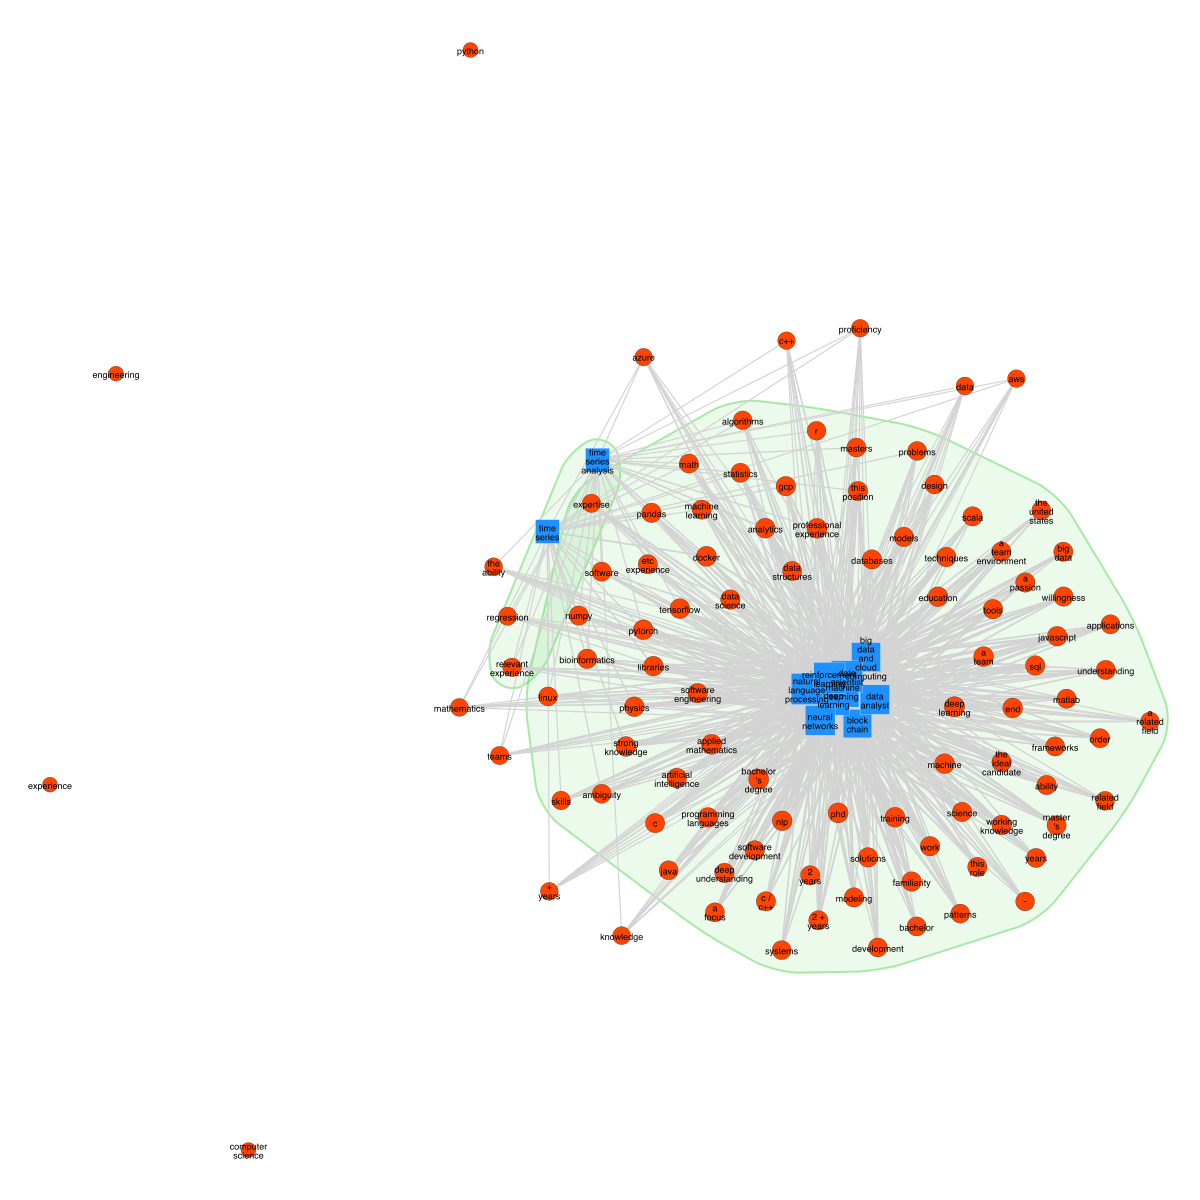

In [30]:
import textnets as tn
from textnets import Corpus


# Separate only the Qualifications and Category Columns
qualifications = agg[['Qualifications', 'category']]

# Expand each listed value in every row to a new row, with the same category
qualifications = qualifications.explode('Qualifications')

# Set the index column to be the category
qualifications = qualifications.set_index('category')

corpus = Corpus(qualifications['Qualifications'])

noun_phrases = corpus.noun_phrases()

#t = tn.Textnet(corpus.tokenized(), min_docs=8, remove_weak_edges=True)
t = tn.Textnet(noun_phrases, min_docs=7, remove_weak_edges=True)
t.plot(label_nodes=True,
       show_clusters=True,
        bbox=(1200, 1200),
        scale_edges_by="weight",
        scale_nodes_by="birank",
        #target="term_network_4.png"
        )

# Responsibilities
# responsibilities = agg[['Responsibilities']]
# responsibilities = responsibilities.explode('Responsibilities')


In [22]:
tn.examples.moon_landing



The Guardian                         3:56 am: Man Steps On to the Moon
New York Times       Men Walk on Moon -- Astronauts Land on Plain, ...
Boston Globe                                         Man Walks on Moon
Houston Chronicle    Armstrong and Aldrich "Take One Small Step for...
Washington Post       The Eagle Has Landed -- Two Men Walk on the Moon
Chicago Tribune      Giant Leap for Mankind -- Armstrong Takes 1st ...
Los Angeles Times    Walk on Moon -- That's One Small Step for Man,...
Name: headlines, dtype: object

In [24]:
# See how many unique categories there are in the agg dataframe
agg['category'].unique()


array(['block chain ', 'natural language processing ',
       'big data and cloud computing ', 'data analyst ',
       'machine learning ', 'reinforcement learning ', 'neural networks ',
       'deep learning ', 'data scientist ', 'time series ',
       'time series analysis '], dtype=object)